In [1]:
! pip install feedparser
! pip install findspark

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.7 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=5edc032749348701ed41ff77cf2e79a7482b10e6a1bb3615a3277fa50b2011f3
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [2]:
import os
import pyspark
import feedparser
import numpy as np
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext 
from datetime import datetime, timedelta
from pyspark.sql.functions import desc, concat, lit, avg, asc, round
import findspark

# Initialize findspark to use PySpark
findspark.init()

# Define application name and master
appName = "project"
master = "local"
# the .jar file in the buscket
jdbc_driver_path = "gs://sys-project-raw/postgresql-42.7.4.jar"
# Create a Spark configuration
conf = pyspark.SparkConf().setAppName(appName) \
    .setMaster(master) \
    .set("spark.jars", jdbc_driver_path) \
    .set("spark.driver.host", "127.0.0.1")

# Create the Spark context with the configuration
sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/14 22:48:27 INFO SparkEnv: Registering MapOutputTracker
24/11/14 22:48:27 INFO SparkEnv: Registering BlockManagerMaster
24/11/14 22:48:27 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/11/14 22:48:27 INFO SparkEnv: Registering OutputCommitCoordinator
/usr/lib/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
data_folder = 'gs://sys-project-raw/data_folder/'
df_total = spark.read.csv(f"{data_folder}/players_15.csv", header=True, inferSchema=True)
df_total = df_total.withColumn("year", lit(2015))
df_total = df_total.withColumn("gender", lit("male"))
# Male
for i in range(16, 23):
    df_tmp = spark.read.csv(f"{data_folder}/players_{i}.csv", header=True, inferSchema=True)
    df_tmp = df_tmp.withColumn("year", lit(2000+i))
    df_tmp = df_tmp.withColumn("gender", lit("male"))
    df_total = df_total.union(df_tmp)

# Female
for i in range(16, 23):
    df_tmp = spark.read.csv(f"{data_folder}/female_players_{i}.csv", header=True, inferSchema=True)
    df_tmp = df_tmp.withColumn("year", lit(2000+i))
    df_tmp = df_tmp.withColumn("gender", lit("female"))
    df_total = df_total.union(df_tmp)

In [4]:
df_total = df_total.withColumn("id", concat(df_total["sofifa_id"], lit("_"), df_total["year"]))
column_order = ["id"] + [col for col in df_total.columns if col != "id"]
df_total = df_total.select(column_order)

In [5]:
df_total = (df_total.withColumn("value_eur", df_total["value_eur"].cast("double"))
                    .withColumn("wage_eur", df_total["wage_eur"].cast("double"))
                    .withColumn("club_team_id", df_total["club_team_id"].cast("integer"))
                    .withColumn("club_jersey_number", df_total["club_jersey_number"].cast("integer"))
                    .withColumn("club_contract_valid_until", df_total["club_contract_valid_until"].cast("integer"))
                    .withColumn("club_joined", df_total["club_joined"].cast("date"))           
           )

# Connect to the Cloud Postgres and write the data into the cloud table

In [6]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="postgres"
db_properties['url']= "jdbc:postgresql://10.9.145.3:5432/postgres"
# "jdbc:postgresql://<private IP>:5432/<database name>"
db_properties['table']="fifa.playerdata"

db_properties['driver']="org.postgresql.Driver"

df_total.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

24/11/14 22:51:33 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


### Injesting the Data from Postgresq

In [7]:
df_total = spark.read.format("jdbc")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.load()

df_total = df_total.filter(df_total["gender"] == "male")

In [8]:
# df_total.show(vertical=True)

### Question 1

In [9]:
from pyspark.sql import functions as F
from pyspark.sql.functions import desc, concat, lit, avg, asc, round


def club_contracts_players(df_total, X, Z, Y):
    filtered_df = df_total.filter(df_total["year"] == X)
    filtered_df = filtered_df.filter(df_total["club_contract_valid_until"] >= Z)
    counts_df = filtered_df.groupBy("club_name").count().sort(desc("count")).limit(Y)
    counts_df.show()

club_contracts_players(df_total, 2015, 2018, 4)

+--------------+-----+
|     club_name|count|
+--------------+-----+
|Fortaleza CEIF|   28|
|    La Equidad|   27|
| Santos Laguna|   27|
| CD Huachipato|   27|
+--------------+-----+



### Question 2

In [10]:
def average_age(df, X, Y, mode):
    if (X <= 0):
        raise ValueError(f"X should be possitive, but get: X = {X}")
    # modifying this
    if not (2015 <= Y <= 2022):
        raise ValueError(f"Y should be a year between 2015 and 2022 inclusively but get: Y = {Y}")
        
    avg_age_df = df.filter(df["year"] == Y).groupBy("club_name").agg(round(avg("age"), 2).alias("avg_age")) # round to 2 decimal
    if mode == "highest":
        avg_age_df = avg_age_df.sort(desc("avg_age"))
    elif mode == "lowest":
        avg_age_df = avg_age_df.sort(asc("avg_age"))
    else:
        raise ValueError(f"Mode should be highest or lowest, but get: {mode}")

    # Check the value of the Xth largest club to make sure output all the valid clubs
    last_val = avg_age_df.collect()[X-1]["avg_age"]
    if mode == "highest":
        counts_df = avg_age_df.filter(avg_age_df["avg_age"] >= last_val)
    else:
        counts_df = avg_age_df.filter(avg_age_df["avg_age"] <= last_val)
    counts_df.show()
    
average_age(df_total, 4, 2022, "highest")
average_age(df_total, 4, 2022, "lowest")

+--------------------+-------+
|           club_name|avg_age|
+--------------------+-------+
|         Guaireña FC|  30.25|
|    12 de Octubre FC|  30.05|
| Shanghai Shenhua FC|  29.89|
|Demir Grup Sivasspor|  29.33|
+--------------------+-------+

+--------------------+-------+
|           club_name|avg_age|
+--------------------+-------+
|     FC Nordsjælland|  20.12|
|      SC Freiburg II|  20.86|
|     Real Sociedad B|  21.16|
|Borussia Dortmund II|  21.46|
+--------------------+-------+



### Question 3

In [11]:
def mostPopularNationality(df_total):
    for year in range(2015, 2023):
        df_year = df_total.filter(df_total["year"] == year).groupBy("nationality_name").count().sort(desc("count")).limit(1)
        print(f"Most popular nationality in the year {year}:", df_year.collect()[0][0])

mostPopularNationality(df_total)

Most popular nationality in the year 2015: England
Most popular nationality in the year 2016: England
Most popular nationality in the year 2017: England
Most popular nationality in the year 2018: England
Most popular nationality in the year 2019: England
Most popular nationality in the year 2020: England
Most popular nationality in the year 2021: England
Most popular nationality in the year 2022: England


# Part 3

## Part 1: Feature Engineering

#### Which features are most important?
We are building a model to predict the overall value for each player based on their SKILLsets.
- THIS IS OUR TARGET VARIABLE: **value_eur (Market value of the player, Euros (numeric))**


The following features stand out to me:
- overall (overall player rating: 0-100)
- potential (potantial player rating 0-100)
- wage_eur (Weekly wage of the player, Euros (numeric))
- age (numeric)
- height_cm (Height of the player, centimeters (numeric))
- league_level (level of the league the club they play for belongs to)
- skill_moves (rating for player skill moves)
- physic (0-100 rating on player's physical strength)

### Part 1a) Data Cleaning and Preprocessing

In [12]:
# CONVERT VARIABLES FROM STRING TO INT THAT ARE SUPPOSED TO BE NUMERIC
# Wage is a string for some reason
# league_level is a string for some reason

# Casting one column type
casted_types_df = (df_total.withColumn("wage_eur_updated", \
                    df_total["wage_eur"] \
                    .cast("integer")).drop("wage_eur")
                    .distinct() # deleting duplicate rows
                  )
casted_types_df = (casted_types_df.withColumn("value_eur_updated", \
                    df_total["value_eur"] \
                    .cast("integer")).drop("value_eur")
                    .distinct() # deleting duplicate rows
                  )
casted_types_df = (casted_types_df.withColumn("league_level_updated", \
                    df_total["league_level"] \
                    .cast("integer")).drop("league_level")
                    .distinct() # deleting duplicate rows
                  )
features_of_interest_df = casted_types_df.select("overall",  "potential", "wage_eur_updated", "age", "height_cm",
                                                 "league_level_updated", "skill_moves", "physic", "value_eur_updated")

# casted_types_df.printSchema()
# casted_types_df.select("wage_eur_updated").distinct().show()
# casted_types_df.select("league_level_updated").distinct().show()

In [13]:
# from lectures 6/7
from pyspark.sql.functions import *

null_counts_features_of_interest_df = features_of_interest_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in features_of_interest_df.columns])

null_counts_features_of_interest_df.show(truncate=False, vertical=True)
print(f"\033[1mOur dataset is {features_of_interest_df.count()} players large, so we can afford to keep physic as a category\033[0m")

-RECORD 0---------------------
 overall              | 0     
 potential            | 0     
 wage_eur_updated     | 1622  
 age                  | 0     
 height_cm            | 0     
 league_level_updated | 2015  
 skill_moves          | 0     
 physic               | 15791 
 value_eur_updated    | 1897  



Our dataset is 142079 players large, so we can afford to keep physic as a category


#### Data Imputing

In [14]:
# This code is from Lecture 6 and 7

# Most of the league levels are the same
from pyspark.ml.feature import Imputer

columns_to_be_imputed = ["league_level_updated"]
value_not_in_dataset = -200

# Replace None/Missing Value with a value that can't be present in the dataset.
df_with_filled_na = features_of_interest_df.fillna(-200, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

df_imputed = imputer.fit(df_with_filled_na).transform(df_with_filled_na)
# we will drop the old column without imputation. We have multiple columns to drop
df_imputed_enhanced = df_imputed.drop(columns_to_be_imputed[0])

# We will rename our newly imputed column with the correct name # You can rename multiple columns at once by chaining.
df_fully_imputed = df_imputed_enhanced.withColumnRenamed("league_level_updated_imputed","league_level")
df_fully_imputed = df_fully_imputed.withColumnRenamed("wage_eur_updated","wage_eur")
df_fully_imputed = df_fully_imputed.withColumnRenamed("value_eur_updated","value_eur")



# I do not want to impute wage because there is such a huge wage and so few nulls and nons, that I would rather just drop the entire row
casted_types_df_with_na_dropped_rows = df_fully_imputed.na.drop()
casted_types_df_with_na_dropped_rows.show(1,vertical=True)

-RECORD 0---------------
 overall      | 75      
 potential    | 75      
 wage_eur     | 40000   
 age          | 32      
 height_cm    | 183     
 skill_moves  | 3       
 physic       | 81      
 value_eur    | 2800000 
 league_level | 1       
only showing top 1 row



### Verifying that there are no more NaNs or Nulls

In [15]:
# from lecture 6 and 7
null_counts_features_of_interest_df = casted_types_df_with_na_dropped_rows.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in casted_types_df_with_na_dropped_rows.columns])
null_counts_features_of_interest_df.show(truncate=False, vertical=True)

-RECORD 0-----------
 overall      | 0   
 potential    | 0   
 wage_eur     | 0   
 age          | 0   
 height_cm    | 0   
 skill_moves  | 0   
 physic       | 0   
 value_eur    | 0   
 league_level | 0   



# Part 2: Feature Engineering (part 2)
### Classifying our chosen variables, we have as follows:
### input:
#### overall
- CONTINUOUS
#### potential
- CONTINUOUS
#### age
- CONTINUOUS
#### height_cm
- CONTINUOUS
#### skill_moves
- ORDINAL (the "difference" between 1 and 2 is different than between 2 and 3, which makes it act more as a category)
#### wage_eur
- CONTINUOUS
#### league_level
- ORDINAL (the "difference" between 1 and 2 is different than between 2 and 3, which makes it act more as a category)
#### physic
- CONTINUOUS

### output:
#### value_eur
- CONTINUOUS

### 2) Summary Statistics

In [16]:
casted_types_df_with_na_dropped_rows.summary().show(truncate=False, vertical=True)

-RECORD 0--------------------------
 summary      | count              
 overall      | 124639             
 potential    | 124639             
 wage_eur     | 124639             
 age          | 124639             
 height_cm    | 124639             
 skill_moves  | 124639             
 physic       | 124639             
 value_eur    | 124639             
 league_level | 124639             
-RECORD 1--------------------------
 summary      | mean               
 overall      | 65.85609640642174  
 potential    | 70.92366755188986  
 wage_eur     | 11467.44678631889  
 age          | 24.933247217965484 
 height_cm    | 180.33877839199607 
 skill_moves  | 2.4915154967546274 
 physic       | 64.81522637376744  
 value_eur    | 2345768.010012917  
 league_level | 1.379552146599379  
-RECORD 2--------------------------
 summary      | stddev             
 overall      | 6.970319270800891  
 potential    | 6.218773803590048  
 wage_eur     | 22705.198229521706 
 age          | 4.4907272795

## This is how we would naively plot the INPUT variables (not correct)
We make the naive plot for two reasons
1) We want to show why we need to separate wage_eur (value_eur is already being separated because it is an output feature)
2) We want to get the summary statistics of all the variables at once

numeric features ['overall', 'potential', 'wage_eur', 'age', 'height_cm', 'skill_moves', 'physic', 'league_level']


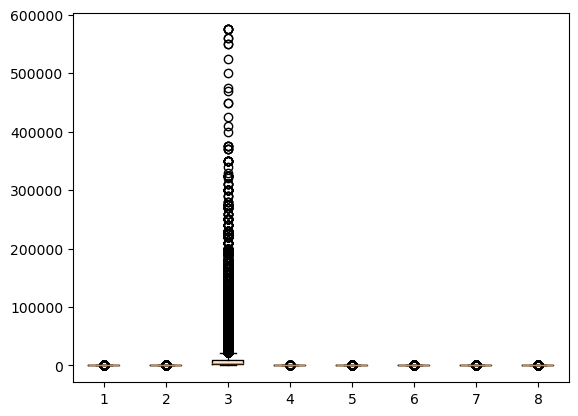

In [17]:
# All from lecture 6 and 7 Notes:

total_summary_df = casted_types_df_with_na_dropped_rows.drop("value_eur")

total_numeric_features = [feature[0] for feature in total_summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", total_numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
total_spotted_data = total_summary_df[total_numeric_features].toPandas()
total_figure_subset = plt.boxplot(total_spotted_data)


### Five-number Summary and Boxplots (Without wage_eur)

numeric features ['overall', 'potential', 'age', 'height_cm', 'skill_moves', 'physic', 'league_level']


dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):
################################
overall
min: 48
Q1: 61.0
median: 66.0
Q3: 70.0
max: 83
################################
potential
min: 55
Q1: 67.0
median: 71.0
Q3: 75.0
max: 87
################################
age
min: 16
Q1: 21.0
median: 25.0
Q3: 28.0
max: 38
################################
height_cm
min: 163
Q1: 176.0
median: 180.0
Q3: 185.0
max: 198
################################
skill_moves
min: 1
Q1: 2.0
median: 2.0
Q3: 3.0
max: 4
################################
physic
min: 37
Q1: 58.0
median: 66.0
Q3: 72.0
max: 92
################################
league_level
min: 1
Q1: 1.0
median: 1.0
Q3: 2.0
max: 3
################################


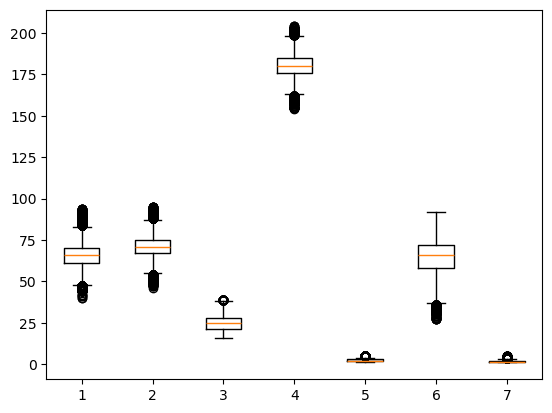

In [18]:
# top section from lecture 6 and 7 Notes:

summary_df = casted_types_df_with_na_dropped_rows.drop("wage_eur").drop("value_eur")

numeric_features = [feature[0] for feature in summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
spotted_data = summary_df[numeric_features].toPandas()
figure_subset = plt.boxplot(spotted_data)

# FIVE NUMBER SUMMARY:

print(figure_subset.keys())
medians = [item.get_ydata()[1] for item in figure_subset['medians']] # used part of a line from lecture 6 and 7 code
all_caps = [item.get_ydata()[1] for item in figure_subset['caps']]
boxes_low = [item.get_ydata()[1] for item in figure_subset['boxes']]
boxes_high = [item.get_ydata()[2] for item in figure_subset['boxes']]

# [item.get_ydata()[1] for item in figure_subset['whiskers']]

print("FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):")
print("################################")
for i in range(len(numeric_features)):
    counter = i*2
    print(f"{numeric_features[i]}")
    print(f"min: {all_caps[counter]}")
    print(f"Q1: {boxes_low[i]}")
    print(f"median: {medians[i]}")
    print(f"Q3: {boxes_high[i]}")
    print(f"max: {all_caps[counter+1]}")
    print("################################")

### Five-number Summary and Boxplots (wage_eur only)

#########################################################################
Wage should be plotted uniquely because its range makes all other variables extremely tiny by comparison
numeric features ['wage_eur']


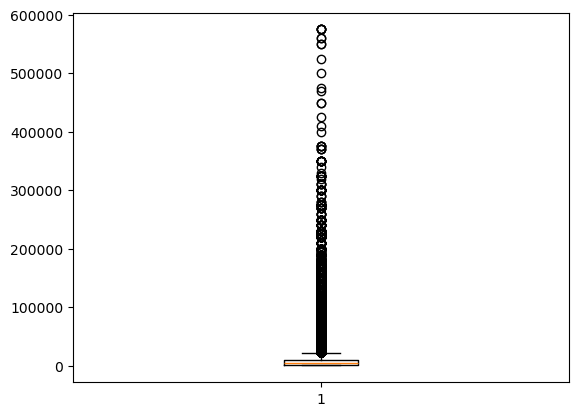

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])
FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):
################################
wage_eur
min: 500
Q1: 2000.0
median: 4000.0
Q3: 10000.0
max: 22000
################################
Wages clearly has a lot of outliers that we will handle in later steps. We are not removing this variable because of how much wage contributes to player value


In [19]:
print("#########################################################################")
print("Wage should be plotted uniquely because its range makes all other variables extremely tiny by comparison")
summary_df = casted_types_df_with_na_dropped_rows.select("wage_eur")

numeric_features = [feature[0] for feature in summary_df.dtypes if feature[1] in ('int','double')]
print("numeric features", numeric_features)

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
spotted_data = summary_df[numeric_features].toPandas()
figure_subset = plt.boxplot(spotted_data)
plt.show()

# FIVE NUMBER SUMMARY:

print(figure_subset.keys())
medians = [item.get_ydata()[1] for item in figure_subset['medians']] # used part of a line from lecture 6 and 7 code
all_caps = [item.get_ydata()[1] for item in figure_subset['caps']]
boxes_low = [item.get_ydata()[1] for item in figure_subset['boxes']]
boxes_high = [item.get_ydata()[2] for item in figure_subset['boxes']]

# [item.get_ydata()[1] for item in figure_subset['whiskers']]

print("FIVE NUMBER SUMMARY FOR EACH VARIABLE (excluding outliers):")
print("################################")
for i in range(len(numeric_features)):
    counter = i*2
    print(f"{numeric_features[i]}")
    print(f"min: {all_caps[counter]}")
    print(f"Q1: {boxes_low[i]}")
    print(f"median: {medians[i]}")
    print(f"Q3: {boxes_high[i]}")
    print(f"max: {all_caps[counter+1]}")
    print("################################")

print("\033[1mWages clearly has a lot of outliers that we will handle in later steps. We are not removing this variable because of how much wage contributes to player value\033[0m")

### 4) Numeric Variables
#### a) Handling Outliers
- we use the total_figure_subset from the naive plot we showed initially

In [20]:
# printing outliers

[print(item.get_ydata()) for item in total_figure_subset['fliers']]

[47 46 47 ... 84 87 86]
[54 54 53 ... 91 88 88]
[ 40000 100000  40000 ...  35000 115000  23000]
[39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39]
[160 155 161 162 158 161 159 162 160 158 162 162 162 158 156 161 161 162
 162 162 156 155 162 155 159 160 161 162 160 158 162 161 162 162 162 161
 161 159 162 161 162 161 161 154 158 162 160 159 157 162 160 161 161 160
 162 162 160 162 160 162 162 158 162 162 162 162 155 162 158 160 158 160
 162 162 160 158 158 158 162 160 156 161 161 162 161 160 161 161 162 159
 162 161 155 162 160 162 158 159 162 162 161 162 162 160 160 160 159 158
 158 160 160 161 162 158 162 161 158 162 161 162 162 162 159 160 162 157
 162 158 160 157 161 155 160 161 159 160 160 161 162 162 160 161 162 159
 160 157 159 159 160 162 159 162 160 156 162 158 162 156 160

[None, None, None, None, None, None, None, None]

In [21]:
# Making use of lecture code

from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [22]:
# From lecture 6 and 7 notes
total_summary_df = casted_types_df_with_na_dropped_rows

df_with_outlier_handling = find_outliers(total_summary_df)
df_with_outlier_handling.show(3, vertical=True)

-RECORD 0-----------------
 overall        | 75      
 potential      | 75      
 wage_eur       | 40000   
 age            | 32      
 height_cm      | 183     
 skill_moves    | 3       
 physic         | 81      
 value_eur      | 2800000 
 league_level   | 1       
 total_outliers | 1       
-RECORD 1-----------------
 overall        | 71      
 potential      | 74      
 wage_eur       | 20000   
 age            | 25      
 height_cm      | 171     
 skill_moves    | 3       
 physic         | 60      
 value_eur      | 1900000 
 league_level   | 1       
 total_outliers | 0       
-RECORD 2-----------------
 overall        | 69      
 potential      | 70      
 wage_eur       | 15000   
 age            | 26      
 height_cm      | 185     
 skill_moves    | 2       
 physic         | 76      
 value_eur      | 975000  
 league_level   | 1       
 total_outliers | 0       
only showing top 3 rows



In [23]:
df_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1|16354|
|             3|  813|
|             4|  382|
|             5|   38|
|             2| 9181|
|             0|97871|
+--------------+-----+



#### We drop all rows with more than 1 outlier. We can expect eur_wage to frequently be an outlier, but we should drop other rows, which barely contribute to the data 

#### We are also dropping rows that contain value_eur as an outlier. While this may not seem ideal on the surface, it is a reasonable approach, since we want the input and the output data to be together BEFORE the data is scaled. 

In [24]:
# inspired from  LECTURE 6 and 7

df_with_substituted_na_and_outliers = df_with_outlier_handling.\
        filter(df_with_outlier_handling['total_outliers']<=1)
print(df_with_substituted_na_and_outliers.count())

df_with_substituted_na_and_outliers.printSchema()

114225
root
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- wage_eur: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- skill_moves: integer (nullable = true)
 |-- physic: integer (nullable = true)
 |-- value_eur: integer (nullable = true)
 |-- league_level: integer (nullable = true)
 |-- total_outliers: integer (nullable = false)



#### b) Identifying High Correlations

In [ ]:
# Making use of lecture code

import seaborn as sb

sb.pairplot(total_spotted_data)

df_corr = df_with_substituted_na_and_outliers.drop("wage_eur")

correlation_matrix = df_corr.toPandas().corr()
print(correlation_matrix)

                 overall  potential       age  height_cm  skill_moves  \
overall         1.000000   0.583472  0.495203   0.059265     0.330108   
potential       0.583472   1.000000 -0.287363   0.008327     0.245732   
age             0.495203  -0.287363  1.000000   0.064425     0.094043   
height_cm       0.059265   0.008327  0.064425   1.000000    -0.279862   
skill_moves     0.330108   0.245732  0.094043  -0.279862     1.000000   
physic          0.501114   0.103664  0.437066   0.487183    -0.173352   
value_eur       0.638224   0.564785  0.084417   0.002836     0.299317   
league_level   -0.181312  -0.151926 -0.041618   0.076538    -0.068019   
total_outliers  0.271676   0.199277  0.086533   0.006816     0.127676   

                  physic  value_eur  league_level  total_outliers  
overall         0.501114   0.638224     -0.181312        0.271676  
potential       0.103664   0.564785     -0.151926        0.199277  
age             0.437066   0.084417     -0.041618        0.086533

#### We drop potential because of its high correlation with overall. Furthermore, since we are calculating the current value of the player on the market, it makes less sense to use potential, since this is more indicative of the player's value in the future

In [ ]:
dropped_corr_df = df_with_substituted_na_and_outliers.drop("potential")

#### Now, we have taken care of all continous and ordinal variables by dropping NaNs, nulls, outliers, and highly correlated features

### 6) Assembling Features Into One Vector

In [27]:
# ALL FROM LECTURE 6 and 7

feature_list = dropped_corr_df.columns
# print(feature_list)

feature_list.remove('value_eur')
print(feature_list)
dropped_corr_df.drop('value_eur')
    
from pyspark.ml.feature import VectorAssembler


vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

df_with_assembled_features = vector_assembler.transform(dropped_corr_df)

df_with_assembled_features.select("vectorized_features").distinct().toPandas()

,vectorized_features
0,"[55.0, 2000.0, 23.0, 183.0, 2.0, 56.0, 1.0, 0.0]"
1,"[66.0, 1000.0, 28.0, 192.0, 2.0, 77.0, 1.0, 0.0]"
2,"[65.0, 10000.0, 21.0, 175.0, 3.0, 59.0, 1.0, 0.0]"
3,"[71.0, 20000.0, 28.0, 187.0, 2.0, 69.0, 1.0, 0.0]"
4,"[71.0, 6000.0, 27.0, 185.0, 2.0, 80.0, 1.0, 0.0]"
...,...
111933,"[75.0, 50000.0, 29.0, 178.0, 3.0, 72.0, 1.0, 1.0]"
111934,"[59.0, 2000.0, 21.0, 172.0, 2.0, 43.0, 1.0, 0.0]"
111935,"[68.0, 8000.0, 22.0, 191.0, 2.0, 75.0, 1.0, 0.0]"
111936,"[68.0, 9000.0, 25.0, 176.0, 2.0, 73.0, 1.0, 0.0]"


### Data Scaling
#### We want to exclude value_eur from this

In [28]:
# ALL FROM LECTURE 6 and 7

from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(df_with_assembled_features)
df_with_scaled_features = scaled_model.transform(df_with_assembled_features)

df_with_scaled_features.select('features').distinct().toPandas()

,features
0,"[10.425741120839056, 0.23024220615546886, 5.28..."
1,"[11.087692938035188, 0.6907266184664066, 5.284..."
2,"[11.253180892334221, 0.46048441231093773, 4.40..."
3,"[10.922204983736155, 0.3453633092332033, 5.945..."
4,"[10.425741120839056, 0.23024220615546886, 4.84..."
...,...
111933,"[11.087692938035188, 0.3453633092332033, 6.165..."
111934,"[9.101837486446795, 0.23024220615546886, 5.504..."
111935,"[11.749644755231317, 1.7268165461660165, 6.165..."
111936,"[9.598301349343894, 0.11512110307773443, 4.403..."


In [29]:
df_with_scaled_features.select('features').distinct().show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+
|[10.425741120839056,0.23024220615546886,5.284712191713586,27.754662334784904,5.196093768816132,6.777359720194075,1.3001372419787718,0.0]             |
|[11.087692938035188,0.6907266184664066,5.284712191713586,28.222437542674538,5.196093768816132,7.298695083285927,1.3001372419787718,0.0]              |
|[11.253180892334221,0.46048441231093773,4.4039268264279885,27.754662334784904,3.464062512544088,7.298695083285927,1.3001372419787718,0.0]            |
|[10.922204983736155,0.3453633092332033,5.945301215677785,27.28688712689527,3.4640625125

In [30]:
df_with_scaled_features.show(5, truncate = False)

+-------+--------+---+---------+-----------+------+---------+------------+--------------+------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|overall|wage_eur|age|height_cm|skill_moves|physic|value_eur|league_level|total_outliers|vectorized_features                       |features                                                                                                                                         |
+-------+--------+---+---------+-----------+------+---------+------------+--------------+------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------+
|75     |40000   |32 |183      |3          |81    |2800000  |1           |1             |[75.0,40000.0,32.0,183.0,3.0,81.0,1.0,1.0]|[12.411596572427449,4.604844123

# Machine Learning Model

In [ ]:
# normalize the label value
from pyspark.sql import functions as F
df_with_scaled_features = df_with_scaled_features.withColumn(
    "value_eur", F.col("value_eur") / 1000000
)

# Pyspark Model

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

def spark_model_train(train_data, test_data, model_type, max_depth, num_trees=None, num_folds=3):
    if model_type == 'decision_tree':
        model = DecisionTreeRegressor(featuresCol="features", labelCol="value_eur", maxDepth=5)
        param_grid = ParamGridBuilder().addGrid(model.maxDepth, max_depth).build()
    elif model_type == 'random_forest':
        model = RandomForestRegressor(featuresCol="features", labelCol="value_eur", maxDepth=5, numTrees=10)
        param_grid = ParamGridBuilder().addGrid(model.numTrees, num_trees).addGrid(model.maxDepth, max_depth).build()
    else:
        assert "model type should be decision_tree or random_forest"

    evaluator = RegressionEvaluator(labelCol="value_eur", metricName="mae")
    crossval = CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
    cv_model = crossval.fit(train_data)
    model_mae = evaluator.evaluate(cv_model.transform(test_data))
    print(f"{model_type} MAE: {model_mae}")

In [ ]:
# Hyperparameter Tuning
train_data, test_data = df_with_scaled_features.randomSplit([0.8, 0.2], seed=42)

# Decision Tree
spark_model_train(train_data, test_data, 'decision_tree', [1, 5, 10]) # no num_trees param for desicion tree
spark_model_train(train_data, test_data, 'decision_tree', [10, 15, 20]) # no num_trees param for desicion tree

# Random Forest
spark_model_train(train_data, test_data, 'random_forest', [1, 5, 10], [5, 10, 20], 3) 


decision_tree MAE: 0.23077385170269063


24/11/14 23:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1028.3 KiB
24/11/14 23:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1522.8 KiB
24/11/14 23:41:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/14 23:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1913.5 KiB
24/11/14 23:46:54 WARN DAGScheduler: Broadcasting large task binary with size 1914.6 KiB
24/11/14 23:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1028.3 KiB
24/11/15 00:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1522.8 KiB
24/11/15 00:04:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
24/11/15 00:08:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
24/11/15 00:13:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/11/15 00:19:40 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
24/11/15 00:25:59 WARN DAGScheduler:

# Pytorch Model

In [7]:
! pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 921.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━

In [43]:
import torch # now import the pytorch module
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.fc(x)

class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size1=64, hidden_size2=128, hidden_size3=256):
        super(DeepNN, self).__init__()
        self.fc_deep = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, hidden_size3),
            nn.ReLU(),
            nn.Linear(hidden_size3, 1)
        )
    def forward(self, x):
        return self.fc_deep(x)

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(np.array(x.tolist()).astype(np.float32))
        self.y = torch.tensor(np.array(y).astype(np.float32))
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]

In [44]:
def pytorch_model_train(train_dataset, test_dataset, bs, lr, epochs, model_type, hidden_size1=64, hidden_size2=128, hiden_size3=256):
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

    input_size = train_dataset[0][0].shape[0]
    if model_type == 'simpleNN':
        model = SimpleNN(input_size, hidden_size1)
    elif model_type == 'deepNN':
        model = DeepNN(input_size, hidden_size1, hidden_size2)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_func = nn.MSELoss()
    batch_loss = 0
    # Train
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            X, y = batch
            optimizer.zero_grad()
            out = model(X)
            loss = loss_func(out.squeeze(), y)
            batch_loss += loss.item()
            loss.backward()
            optimizer.step()
        # print(f"Epoch{epoch} MSE Loss: {batch_loss/len(train_loader)}")
    # Test -  if the metric is MSE
    model.eval()
    with torch.no_grad():
        pred = []
        label = []
        for batch in test_loader:
            X, y = batch
            out = model(X)
            pred.extend(out.squeeze().numpy())
            label.extend(y.numpy())
    test_mse = np.mean((np.array(pred) - np.array(label)) ** 2)
    print(f"The test MSE is {test_mse}")

In [45]:
from sklearn.model_selection import train_test_split
data_pd = df_with_scaled_features.toPandas()
X_pd = data_pd['features']
y_pd = data_pd['value_eur']
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.2, random_state=42)
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [46]:
# Hyperparameters Tuning

# simple NN
print("Param: bs=8, lr=1e-2, epochs=20, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 20, 'simpleNN', 64, 128, 256)
print("Param: bs=8, lr=1e-2, epochs=40, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 40, 'simpleNN', 64, 128, 256)
print("Param: bs=8, lr=1e-3, epochs=40, type=simpleNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-3, 40, 'simpleNN', 64, 128, 256)

print("---------------------------------------------------")
# Deep NN
print("Param: bs=8, lr=1e-2, epochs=20, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 20, 'deepNN', 64, 128, 256)
print("Param: bs=8, lr=1e-2, epochs=40, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-2, 40, 'deepNN', 64, 128, 256)
print("Param: bs=8, lr=1e-3, epochs=40, type=deepNN")
pytorch_model_train(train_dataset, test_dataset, 8, 1e-3, 40, 'deepNN', 64, 128, 256)

Param: bs=8, lr=1e-2, epochs=20, type=simpleNN
The test MSE is 0.6395081877708435
Param: bs=8, lr=1e-2, epochs=40, type=simpleNN
The test MSE is 0.4980848431587219
Param: bs=8, lr=1e-3, epochs=40, type=simpleNN
The test MSE is 0.42993074655532837
---------------------------------------------------
Param: bs=8, lr=1e-2, epochs=20, type=deepNN
The test MSE is 1.0700135231018066
Param: bs=8, lr=1e-2, epochs=40, type=deepNN
The test MSE is 0.5084910988807678
Param: bs=8, lr=1e-3, epochs=40, type=deepNN
The test MSE is 0.32678431272506714
